In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

#For reproducibility
np.random.seed(999)

## Set-up

The cell below sets up the game environment and the player objects. The implementation is designed for a 2-player, general sum, repeated matrix game. Players can either access the previous actions taken or have no memory.

In [3]:
class MatrixGame(gym.Env):
    def __init__(self,reward_matrix,memory=False):
        """
        reward_matrix : ndarray, scores for each player in each outcome
        memory: bool, Whether to store the previous game's action for the players to see
        """
        super().__init__()
        self.reward_matrix = reward_matrix
        self.memory = memory

        #Get number of possible actions
        n = self.reward_matrix.shape[0]

        #Set up the action space as 2-tuples with each value in {0,...,n}
        self.action_space = gym.spaces.MultiDiscrete([n,n])

        #get number of players
        num_players = len(self.reward_matrix.shape)-1

        #If memory.Observations are array of shape (history,2) to the previous actions
        if memory:
            self.observation_space = gym.spaces.MultiDiscrete((n,n))
        else:
            self.observation_space = gym.spaces.Discrete((1))

        #Max and min possible rewards, used later for plotting
        self.max_reward = self.reward_matrix.max()
        self.min_reward = self.reward_matrix.min()

        #Define state variable:
        self.state = None


    def reset(self):
        """Resets the environment"""
        if self.memory:
            self.state = self.observation_space.sample()
        else:
            self.state = np.array([0])
        return self.state, None

    def step(self, action):
        """ 
        Args:
            action: tuple, contains all actions of agents in this instance

        Returns:
            observation: None, No observation in this game
            reward: tuple, Reward for each agent
        """
        
        #Add most recent action to top of state, delete last action
        if self.memory:
            self.state = action


        #Calculate reward for given action
        reward = self.reward_matrix[*action]

        return self.state, reward
    

class Player():
    def __init__(self,env, epsilon = 10e-2):
        """
        env: gym.Env, enviroment the player will be playing in
        epsilon: float, Exploration rate
        alpha: float, Learning rate for Q-learning
        """
        self.epsilon = epsilon

        #stores how many actions the player has
        self.n = env.action_space[0].n

        #stores shape of state space
        self.s = env.observation_space.shape

        #stores how much memory the agent has
        self.memory = env.memory
        
        self.reset()
    

    def reset(self):
        #Q Table to be used for state-action values, shape is (n,) if no memory else (n,n,n)
        if self.memory:
            self.Q = np.zeros((self.n,self.n,self.n))
        else:
            self.Q = np.expand_dims(np.zeros((self.n)),0)

    def act(self,state):
        p = np.random.rand()

        #Load the action values for the current state
        q = self.Q[*state]

        #epsilon greedy action selection
        if p<self.epsilon:
            return np.random.randint(self.n)
        else:
            return np.random.choice(np.flatnonzero(np.isclose(q,q.max())))
        
        

## Learning Algorithm and training functions:
This has been implemented using Q-Learning for the agents. The update rule for Q-learning is as follows: 
$$ Q(S_t,A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} +\gamma\max_a Q(s_{t+1},a) - Q(S_t,A_t)]$$
In the stateless version, there is only one state, so it is just the action values that are updated.

In [4]:
def update_players(players, old_state,new_state, actions, rewards, alpha=10e-2, gamma = 10e-2):
    """
    players: tuple, Players to be updated
    old_state: ndarray, State of action before action taken
    new_state: ndarray, State ended up in after action taken
    action: tuple, Action taken by players
    reward: tuple, Reward received
    alpha:, float, Learning rate
    """
    for i,player in enumerate(players):
        player.Q[*old_state][actions[i]] = (1-alpha)*player.Q[*old_state][actions[i]] + alpha*(rewards[i] + gamma*player.Q[*new_state].max())
    

def train_one_epoch(env, players, alpha = 10e-2,gamma = 10e-2):
    """
    env: gym.Env, game environment
    players: tuple, players in game
    alpha: float, learning rate
    """
    
    old_state = env.state
    actions = [player.act(old_state) for player in players]
    new_state, rewards, = env.step(actions)
    update_players(players, old_state,new_state,actions, rewards, alpha,gamma)


    return rewards


def train(env,players,num_epochs, num_runs, alpha = 10e-2,gamma = 10e-2):
    """
    Args:
        env: gym.Env, game environment
        players: tuple, players in game
        num_epochs: int, how many epochs to play to the game for each run
        num_runs:int, total number of runs
        alpha: float, learning rate

    Returns:
        average_reward: ndarray, shape = [num_plauers, num_epochs], average reward received by each player at each epoch
        average_policy: ndarray, shape = [num_plauers, num_epochs], average probability of choosing 1 for each player at each epoch
    """

    #Summary statistics for plotting
    total_rewards = []
    total_policies = []

    for i in range(num_runs):

        #reset game at start of each run
        env.reset()
        for player in players:
            player.reset()

        #list of rewards and policy values for this run
        r = []
        q = []

        #simulate this run
        
        for epoch in range(num_epochs):
            rewards = train_one_epoch(env, players, alpha,gamma)
            q.append([player.Q.argmax(-1) for player in players])
            r.append(rewards)            

        total_rewards.append(r)
        total_policies.append(q)


    #calculate average over number of runs
    average_reward = np.array(total_rewards).mean(0).T
    average_policy = np.array(total_policies).mean(0).T
    # average_policy = np.zeros_like(average_reward)


    return average_reward,average_policy


## Hyperparameters

The cell below lets you adjust the reward matrix and the hyperparameters of the experiment. 
- `reward_matrix` = the rewards received for each action, also encodes the structure of the game
- `num_epochs` = number of rounds to repeat the game for 
- `num_runs` = number of full runs to simulate
- `alpha` = learning rate
- `epsilon` = exploration rate
- `gamma` = discount factor
- `memory` = True if the agent can access the last round actions, False for a stateless run

In [43]:
reward_matrix = np.array([
    [[2,2],[0,3]],
    [[3,0],[1,1]]
])

num_epochs = 1000
num_runs = 1000
alpha = 10e-1
epsilon = 10e-2
gamma = 0
memory = True

## Experiment

Run the cell below to execute the experiment for the hyperparameters above. The results will be plotted below. For 1 Million games It took around 2-3 Minutes.

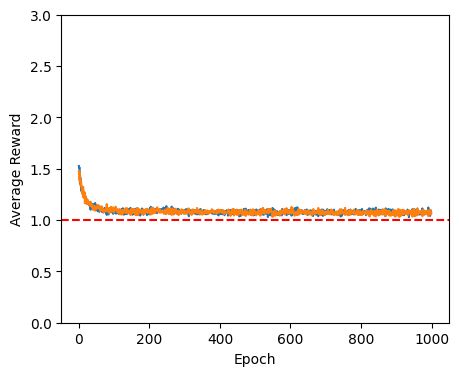

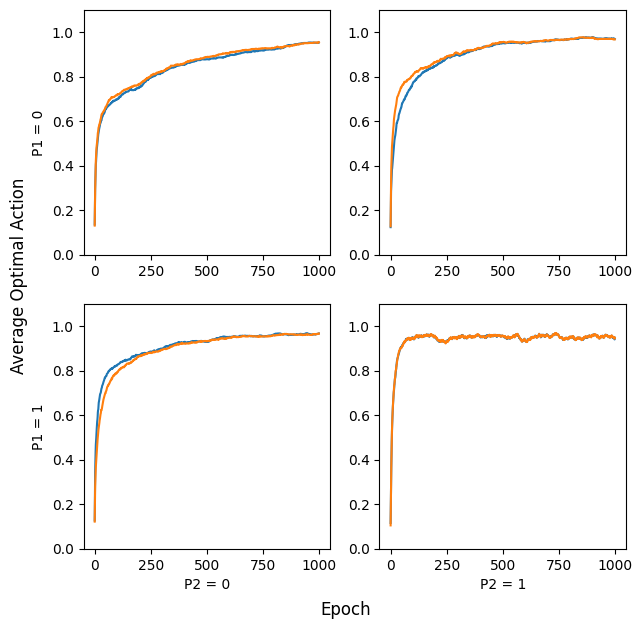

In [44]:
def run_experiment(reward_matrix, num_epochs,num_runs, alpha=10e-2, epsilon = 10e-2, gamma = 10e-2, memory = False):
    n = reward_matrix.shape[-1] #number of players
    env = MatrixGame(reward_matrix, memory = memory)
    players = [Player(env, epsilon=epsilon) for i in range(n)] #list of players

    average_reward, average_policy = train(env, players,num_epochs, num_runs, alpha,gamma)

    return average_reward, average_policy


av_reward, av_policy = run_experiment(reward_matrix, num_epochs, num_runs,alpha,epsilon,gamma, memory)


fig,ax = plt.subplots(figsize = (5,4))

ax.plot(np.arange(num_epochs), av_reward[0])
ax.plot(np.arange(num_epochs), av_reward[1])

# Change the ylim to make the plots look nicer. Ideally it would go from 0 to the maximum reward you are interested in.
ax.set(xlabel = 'Epoch', ylabel = 'Average Reward',ylim = [0,3])

#This is a control line of some optimal reward
ax.axhline(y=1, color='r', linestyle='dashed')

if memory:
    s = av_policy.shape
    fig, axs = plt.subplots(nrows = s[0], ncols = s[1], figsize = (7,7))

    fig.supylabel('Average Optimal Action')
    fig.supxlabel('Epoch')

    plt.setp(axs, ylim=[0,s[1]-1+0.1])

    for i in range(s[0]):
        for j in range(s[1]):
            axs[i][j].plot(np.arange(s[-1]), av_policy[i,j,0])
            axs[i][j].plot(np.arange(s[-1]), av_policy[i,j,1])

            if j ==0:
                axs[i][j].set_ylabel(f'P1 = {i}')

            if i ==1:
                axs[i][j].set_xlabel(f'P2 = {j}')
        

    plt.show()
else:
    fig,ax = plt.subplots(figsize = (5,4))
    s = av_policy.shape
    ax.plot(np.arange(s[-1]),av_policy[0,0])
    ax.plot(np.arange(s[-1]),av_policy[0,1])
    ax.set(xlabel = 'Epoch', ylabel = 'Average Optimal Action',ylim = [0,s[1]-1 + 0.1])

    plt.show()
        